In [1]:
import boto3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Data Import

According to [data dictionary for iris dataset](https://s3.amazonaws.com/jakechenawspublic/tutorials/sample_data/iris-names.txt) the columns in this dataset are:

Attribute Information:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica

In [2]:
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'iris_class']
raw = pd.read_csv('s3://jakechenawspublic/tutorials/sample_data/iris/iris.csv', names=names)

## Split Train/Test

In [3]:
from sklearn.model_selection import train_test_split
X_cols = set(raw.columns)-set(['iris_class'])
X = raw[list(X_cols)]
y = raw['iris_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## EDA

We should already have completed this step in either [AWS Athena](https://aws.amazon.com/athena) or [AWS Quicksight](https://quicksight.aws/) before even spinning up this notebook and importing the data in the last section. If not then we'll quickly reproduce the EDA findings here.

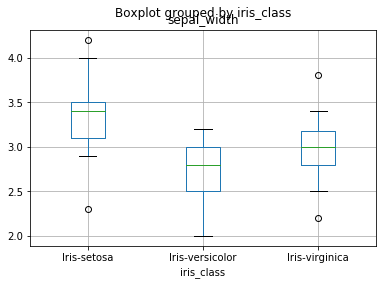

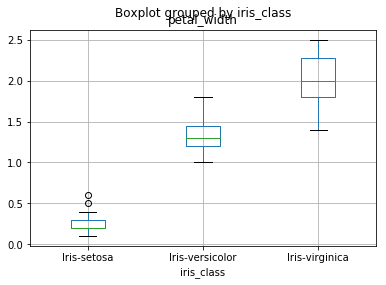

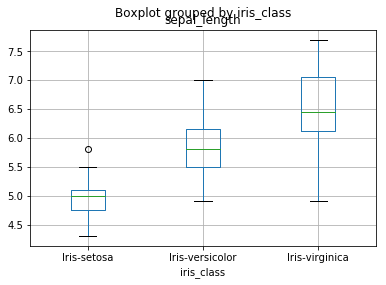

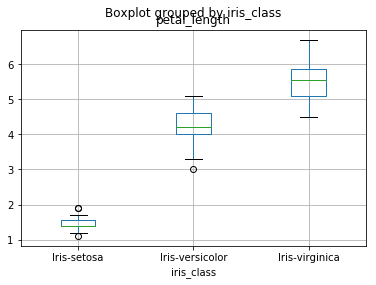

In [4]:
data = pd.concat([X_train, y_train], axis=1)
for cols in (set(data.columns)-set(['iris_class'])):
    data.boxplot(cols,'iris_class')

From the EDA performed in Athena and/or Quicksight, we should have gotten the following insights:

- Both petal length and petal width are useful in differentiating Setosa from the other two classes
- Versicolor and Virginica show some overlap in all provided features

## Data Preparation

In simple data sets, data preparation step could just consist of easy tasks such as null removal and data subsetting. In complex cases though, such as those with large dimensions, this step could also consist of transformations that need pre-training, such as dimension reduction using Principle Components Analysis.

Based on the EDA performed before, we will choose a simple transformation: subsetting the data to only include petal_length, petal_width, and iris_class.

### Fit and store feature selector

In [5]:
# Fit a feature selector that only takes the top 2 most important variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
feature_selector = SelectKBest(chi2, k=2)
X_train2 = feature_selector.fit_transform(X_train, y_train)

In [6]:
col_names = feature_selector.transform(X_train.columns.tolist())[0]
X_train2 = pd.DataFrame(X_train2, columns=col_names)

/usr/local/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [7]:
# Pickle and store feature selector to S3
import pickle
fs_pickle = pickle.dumps(feature_selector)

s3_resource = boto3.resource('s3')
s3_bucket = 'jakechenawspublic'
s3_key = 'tutorials/mlstack_demo/transforms/feature_selector.pickle'
s3_resource.Object(s3_bucket, s3_key).put(Body=fs_pickle)

{u'ETag': '"cfbf3a6602aeb6db9f51d0e49d86e482"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Sat, 01 Apr 2017 23:05:38 GMT',
   'etag': '"cfbf3a6602aeb6db9f51d0e49d86e482"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'J8nlS8MoIK1lhS3FvgzyYGgNfq4TIhf3btpTfLpf9xidON0ScjIC/D7BhxQShL0wET/E2fUGOrU=',
   'x-amz-request-id': 'E95CD2753AE8A84E'},
  'HTTPStatusCode': 200,
  'HostId': 'J8nlS8MoIK1lhS3FvgzyYGgNfq4TIhf3btpTfLpf9xidON0ScjIC/D7BhxQShL0wET/E2fUGOrU=',
  'RequestId': 'E95CD2753AE8A84E',
  'RetryAttempts': 0}}

### Transform and store training data

In [8]:
# Merge X_train with y_train before storing into S3
df_train = pd.concat([X_train2, y_train.reset_index(drop=True)], axis=1)

s_train = df_train.to_csv(None, index=None)

s3_resource = boto3.resource('s3')
s3_bucket = 'jakechenawspublic'
s3_key = 'tutorials/mlstack_demo/data/intermediary/post_transform.csv'
s3_resource.Object(s3_bucket, s3_key).put(Body=s_train)

{u'ETag': '"b413240743857d6dfb4fb73c7e7dad1f"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Sat, 01 Apr 2017 23:05:38 GMT',
   'etag': '"b413240743857d6dfb4fb73c7e7dad1f"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'XeIFsAWvDgY6oBBknkw86Xg8Q0FdhFrrp/XqTEvxzBynxzA3coh9sW/iSP0NVVB7dv2o26mh1qw=',
   'x-amz-request-id': '473E998E1178DB97'},
  'HTTPStatusCode': 200,
  'HostId': 'XeIFsAWvDgY6oBBknkw86Xg8Q0FdhFrrp/XqTEvxzBynxzA3coh9sW/iSP0NVVB7dv2o26mh1qw=',
  'RequestId': '473E998E1178DB97',
  'RetryAttempts': 0}}

## Model Training + Evaluation

### Model training

In [9]:
raw = pd.read_csv('s3://jakechenawspublic/tutorials/mlstack_demo/data/intermediary/post_transform.csv')

In [10]:
x_cols = set(raw.columns.values)-set(['iris_class'])
X_train = raw[list(x_cols)]
y_train = raw['iris_class']

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [12]:
cfr = DecisionTreeClassifier()
cfr.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Prediction pipeline

In [13]:
import boto3
import pickle

# get pickled feature selector from s3
s3_resource = boto3.resource('s3')
s3_bucket = 'jakechenawspublic'
s3_key = 'tutorials/mlstack_demo/transforms/feature_selector.pickle'
fs_string = s3_resource.Object(s3_bucket, s3_key).get()['Body'].read()

In [14]:
# load feature selector from pickle
feature_selector = pickle.loads(fs_string)

In [15]:
# run feature selector on test dataset
X_test2 = feature_selector.transform(X_test)

In [16]:
# run model on transformed test dataset
y_pred = cfr.predict(X_test2)

In [17]:
print confusion_matrix(y_test, y_pred)

[[19  0  0]
 [ 0 15  0]
 [ 0  1 15]]


## Store Trained Model

If this model looks good then let's store the model

In [18]:
# Pickle and store feature selector to S3
import pickle
cfr_pickle = pickle.dumps(cfr)

s3_resource = boto3.resource('s3')
s3_bucket = 'jakechenawspublic'
s3_key = 'tutorials/mlstack_demo/models/tree_cfr.pickle'
s3_resource.Object(s3_bucket, s3_key).put(Body=cfr_pickle)

{u'ETag': '"4f5e722280946cebfc62235f9da9e396"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Sat, 01 Apr 2017 23:05:38 GMT',
   'etag': '"4f5e722280946cebfc62235f9da9e396"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'q+cyXpx6xGO9kP/cIyX+xuyYnqSaNEtrst6/EUwHe85NNgfWJFu6v3j0nEooeoQ8p5u9TUC+O2M=',
   'x-amz-request-id': '11BE3ACF68587867'},
  'HTTPStatusCode': 200,
  'HostId': 'q+cyXpx6xGO9kP/cIyX+xuyYnqSaNEtrst6/EUwHe85NNgfWJFu6v3j0nEooeoQ8p5u9TUC+O2M=',
  'RequestId': '11BE3ACF68587867',
  'RetryAttempts': 0}}